In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from generation.dataset.data_utils import get_event_detector_df, \
get_event_detector_signal, get_event_detector_df_path, \
get_detector_training_data

In [2]:
_DETECTOR = 0
_EVENTS_NUM = 200


signals = get_detector_training_data(_DETECTOR)

### Data preparation

In [3]:
from sklearn.preprocessing import MinMaxScaler

from generation.dataset.dataset_pytorch import SignalsDataset

In [4]:
SAMPLE_SIZE = 2048




origin_data = signals.copy()[:, :SAMPLE_SIZE]
data = unify_shape(origin_data)
data = data[~np.isnan(data).any(axis=1)]
origin_noises = data - np.mean(data, axis=0)
noises_dataset, noises_scaler, noises = get_dataset(origin_noises)

/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [5]:
fft_noises = np.fft.rfft(noises)
real_noises = np.real(fft_noises)
img_noises = np.imag(fft_noises)

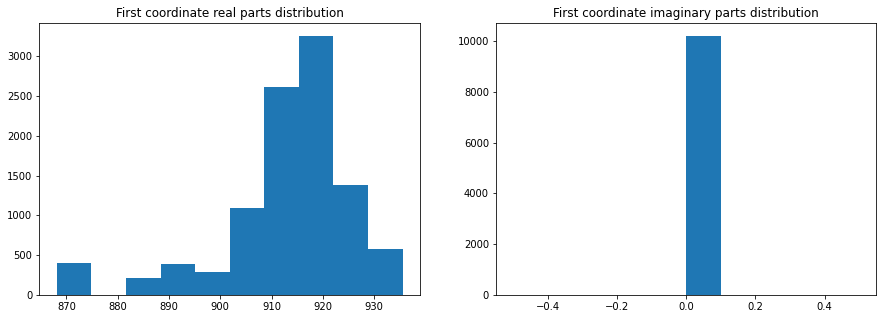

In [6]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title("First coordinate real parts distribution")
ax[0].hist(real_noises[:, 0])
ax[1].set_title("First coordinate imaginary parts distribution")
ax[1].hist(img_noises[:, 0])
plt.show()

##### We do not have to use the first coordinate after fft transform, as it responsible only for absolute shift

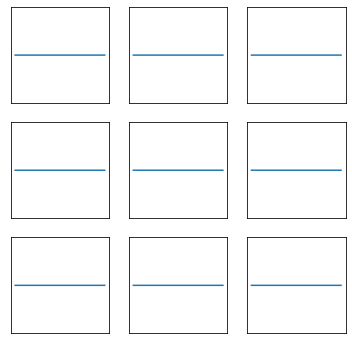

In [7]:
first_real = 0
first_img = 0

f, ax = plt.subplots(3, 3, figsize=(6, 6))

for i in range(9):
    idx = np.random.choice(range(len(noises)))
    new_real = np.concatenate([[first_real], real_noises[idx][1:]])
    new_img = np.concatenate([[first_img], img_noises[idx][1:]])
    new_signal = np.real(np.fft.irfft(new_real + (1j * new_img)))
    ax[i // 3][i % 3].set_xticks([])
    ax[i // 3][i % 3].set_yticks([])
    ax[i // 3][i % 3].plot(np.round(new_signal - noises[idx], 5))
plt.show()

In [8]:
real_noises = real_noises[:, 1:]
img_noises = img_noises[:, 1:]

### Scatter plots after fourier transform

In [9]:
def plot_scatter():
    f, ax = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(9):
        idx = np.random.choice(range(len(fft_noises)))
        ax[i // 3][i % 3].scatter(real_noises[idx], img_noises[idx])

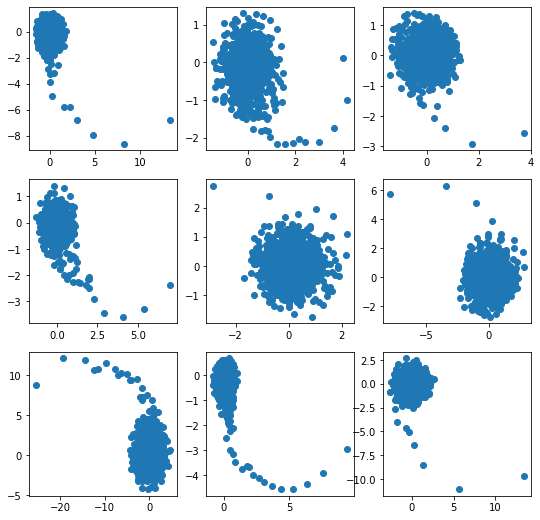

In [10]:
plot_scatter()

#### Scaling

In [11]:
img_scaler = Scaler()
img_noises = img_scaler.fit_transform(img_noises)

real_scaler = Scaler()
real_noises = real_scaler.fit_transform(real_noises)

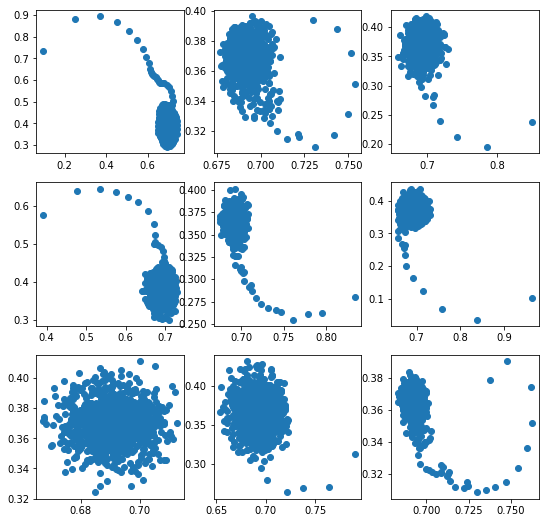

In [12]:
plot_scatter()

### Saving data

In [88]:
from IPython.core.pylabtools import figsize
figsize(0.5, .51)  # Square image

_DATA_DIR = '/home/pafakanov/data/hep_data/spacal_simulation/1GeV/fft_images'

def get_image_path(idx):
    return os.path.join(_DATA_DIR, str(idx)) + '.png'

def save_image(idx):
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.axis('off')
    plt.scatter(real_noises[idx], img_noises[idx], color='black')
#     plt.plot()
    plt.savefig(get_image_path(idx), bbox_inches='tight', transparent=True, pad_inches=0)
    plt.clf()

In [89]:
save_image(0)
io.imread(get_image_path(0)).shape

(27, 27, 4)

<Figure size 36x36.72 with 0 Axes>

In [90]:
import multiprocessing as mp

_PROCESSORS_NUM = 16


idxs = range(len(real_noises))
with mp.Pool(_PROCESSORS_NUM) as pool:
    list(tqdm.tqdm(pool.imap(save_image, idxs), total=len(idxs)))

100%|██████████| 10200/10200 [01:40<00:00, 101.05it/s]
